# Data Preparation and cleaning

## Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import os
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
orders_path = '../orders_additional_cleaned.csv'

df_orders = pd.read_csv(orders_path,
                        dtype=
                        {'Customer number': object,
                         'Gender': 'category',
                         'PoR': object,
                         'Order number': object,
                         'Product number': object,
                         'Sub category': 'category',
                         'Category': 'category',
                         'Count': np.int16,
                         'Price': np.float64,
                         'EDT': np.int16,
                         'ADT': np.int16,
                         'RoR': object,
                         'Rating': np.int8})

df_orders["Order date"] = pd.to_datetime(df_orders["Order date"], format="%d-%m-%Y")
df_orders["DoB"] = pd.to_datetime(df_orders["DoB"], format="%d-%m-%Y")

## Feature engineering

### "Returned"
    -> binary value
    -> is the product retured or not

In [3]:
df_orders.loc[df_orders['RoR'].isnull(), 'Returned'] = 0
df_orders.loc[df_orders['RoR'].notnull(), 'Returned'] = 1
df_orders = df_orders.drop('RoR', axis=1)

### "Price per product"
    -> what is the price of the product ordered

In [4]:
df_orders['Price per Product'] = df_orders['Price'] / df_orders['Count']

### "Man" / "Woman"
    -> boolean values
    -> is the gender man or woman
    -> the method is called One-Hot-Encoding. It is done instead of changing the genders to 0 and 1 in the original column, so the models in the future can diferentiate them like categories, not numbers
    -> as there are statistically unimportant number of missing gender values, we will make both columns 'Man' and 'Woman' = 0

In [5]:
df_orders.loc[df_orders['Gender'] == "Man", 'Man'] = 1
df_orders.loc[df_orders['Gender'] == "Woman", 'Man'] = 0
df_orders.loc[df_orders['Gender'] == "Man", 'Woman'] = 0
df_orders.loc[df_orders['Gender'] == "Woman", 'Woman'] = 1

In [6]:
df_orders['Man'].replace(np.nan, 0, inplace=True)
df_orders['Woman'].replace(np.nan, 0, inplace=True)

### "Age" 
    -> based on the date of birth

In [7]:
today = dt.datetime.today()

df_orders["DoB"] = pd.to_datetime(df_orders["DoB"], format="%d-%m-%Y")
df_orders["Age"] = today.year - df_orders["DoB"].dt.year - ((today.month <= df_orders["DoB"].dt.month)
                                                            & (today.day <= df_orders["DoB"].dt.day))

### "Order month" and "Order year"
    -> separate the month and the year of an order for easier analysis

In [8]:
df_orders["Order date"] = pd.to_datetime(df_orders["Order date"], format="%d-%m-%Y")
df_orders["Order month"] = df_orders["Order date"].dt.month
df_orders["Order year"] = df_orders["Order date"].dt.year

### "DeltaT"
    -> number representation of the days
    -> the 0 day is 01-01-2013 and each next day is +1

In [9]:
first_order = pd.to_datetime("01-01-2013", format="%d-%m-%Y")
df_orders["DeltaT"] = (df_orders["Order date"] - first_order).dt.days

## Current information about the dataset

In [10]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664808 entries, 0 to 664807
Data columns (total 22 columns):
Customer number      664808 non-null object
DoB                  664808 non-null datetime64[ns]
Gender               664808 non-null category
PoR                  664808 non-null object
Order number         664808 non-null object
Order date           664808 non-null datetime64[ns]
Product number       664808 non-null object
Sub category         664808 non-null category
Category             664808 non-null category
Count                664808 non-null int16
Price                664808 non-null float64
EDT                  664808 non-null int16
ADT                  664808 non-null int16
Rating               664808 non-null int8
Returned             664808 non-null float64
Price per Product    664808 non-null float64
Man                  664808 non-null float64
Woman                664808 non-null float64
Age                  664808 non-null int64
Order month          664808 non-

# Exploratory Data Analysis (EDA)

## Gender distribution

In [11]:
unique_gender = df_orders[['Customer number', 'Man', 'Woman']]
unique_gender = unique_gender.drop_duplicates('Customer number')

male = unique_gender[unique_gender['Man'] == 1]
female = unique_gender[unique_gender['Woman'] == 1]

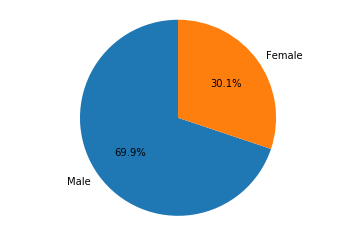

In [12]:
labels = 'Male', 'Female'
sizes = [len(male), len(female)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

plt.show()

## Age distribution

In [13]:
customers_age = df_orders[['Customer number', 'Age']]
customers_age = customers_age.drop_duplicates('Customer number')

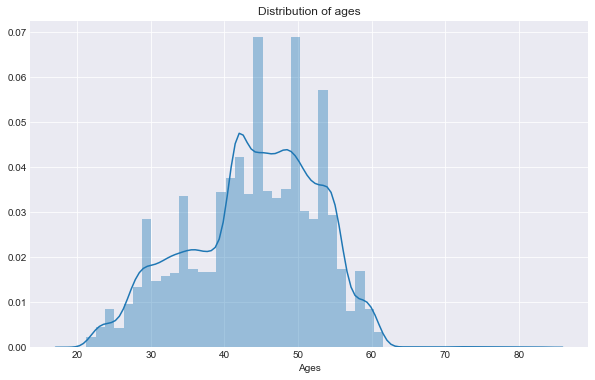

In [14]:
sns.set_style('darkgrid')
x = pd.Series(customers_age['Age'], name="Ages")
plt.subplots(figsize=(10,6))
sns.distplot(x)
plt.title("Distribution of ages")
print()

## Categories and subcategories

In [15]:
df_ordered_categories = df_orders.groupby(['Category', 'Sub category'])
print(df_ordered_categories[['Category', 'Sub category']].nunique().to_string())

                                                              Category  Sub category
Category          Sub category                                                      
Control           Grout brushes                                      1             1
                  Insects and vermin                                 1             1
                  Insects and vermin (2-pack)                        1             1
                  Weed brush                                         1             1
                  Weed brush (2-pack)                                1             1
                  Weed burner                                        1             1
                  Weed burner (2-pack)                               1             1
                  \                                                  1             1
                  Grout brushes (2-pack)                             1             1
Garden decoration Garden gnomes                                  

## Money earned per category

In [16]:
money_per_category = df_orders.groupby(['Category'])['Price'].sum()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
money_per_category

Category
Control               8842284.570
Garden decoration    23584098.970
Garden furniture    152726203.840
Garden hand tools     1205762.320
Garden heating       10666121.230
Garden reamers        3151244.580
Gardening tools       7716267.650
Lounge furniture     37560152.840
Other furniture       8138896.750
Pruning               6157488.620
Sun protection       37030069.370
Watering             16495131.270
Name: Price, dtype: float64

## Distribution of orders per customer

In [17]:
df_orders = df_orders.sort_values(['Customer number', 'Order date'])

orders_per_customer = df_orders[['Customer number', 'Order number']]
orders_per_customer = orders_per_customer.groupby('Customer number')['Order number'].count().reset_index()
orders_per_customer.rename(columns = {'Order number' : 'Number of orders'}, inplace=True)

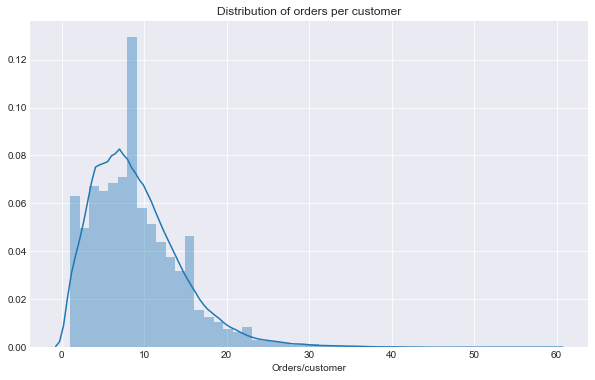

In [18]:
sns.set_style('darkgrid')
x = pd.Series(orders_per_customer['Number of orders'], name="Orders/customer")
plt.subplots(figsize=(10,6))
sns.distplot(x)
plt.title("Distribution of orders per customer")
print()

## Replacing all -1 values with NaN in 'Rating'

In [19]:
df_orders['Rating'].replace(-1, np.nan, inplace=True)

## Average rating per customer

In [20]:
rating_per_customer_avg = df_orders[['Customer number', 'Rating']]
rating_per_customer_avg.head()

,Customer number,Rating
582635,1004533,2.000
583174,1004533,2.000
576205,1004533,nan
579645,1004533,nan
580515,1004533,nan


In [21]:
rating_per_customer_avg = rating_per_customer_avg.groupby('Customer number')['Rating'].mean().reset_index()

### Give all people that haven't given raiting an average raiting value of -1

In [22]:
rating_per_customer_avg['Rating'].replace(np.nan, -1, inplace=True)
rating_per_customer_avg.rename(columns = {'Rating' : 'Average rating'}, inplace=True)

## Estimated date of arrival / actual date of arrival

In [23]:
df_average_edt_divided_by_adt_per_customer = df_orders[['Customer number', 'EDT', 'ADT', 'Age']]

In [24]:
df_average_edt_divided_by_adt_per_customer = df_average_edt_divided_by_adt_per_customer.groupby('Customer number')['EDT', 'ADT'].mean().reset_index()

In [25]:
df_average_edt_divided_by_adt_per_customer['EDT_divided_ADT'] = df_average_edt_divided_by_adt_per_customer['EDT'] / df_average_edt_divided_by_adt_per_customer['ADT']

In [26]:
df_average_edt_divided_by_adt_per_customer.head()

,Customer number,EDT,ADT,EDT_divided_ADT
0,1004533,2.636,5.455,0.483
1,1004534,5.833,10.500,0.556
2,1004535,3.154,6.538,0.482
3,1004536,3.500,6.625,0.528
4,1004537,4.333,7.467,0.580


## Percent returned items

In [27]:
returns_per_customer = df_orders[['Customer number', 'Returned']]
total_returns = returns_per_customer.groupby('Customer number')['Returned'].count()
actual_returns = returns_per_customer[returns_per_customer['Returned'] == 1].groupby('Customer number')['Returned'].count()

returns_per_customer = returns_per_customer.drop_duplicates('Customer number')
returns_per_customer = returns_per_customer.drop('Returned', axis=1)

percentage_returned = actual_returns.divide(total_returns, fill_value=0).to_frame()
returns_per_customer = pd.merge(returns_per_customer, percentage_returned, how='left', on='Customer number')

## Churn analysis

### Get dates of orders per customer

In [28]:
dates_per_customer = df_orders[['Customer number', 'Order number', 'Order date']]
dates_per_customer = dates_per_customer.drop_duplicates('Order number')
dates_per_customer = dates_per_customer.drop('Order number', axis=1)

In [29]:
customer_dates = dates_per_customer.groupby('Customer number')['Order date'].apply(lambda x: x.tolist())
customer_dates_dict = customer_dates.to_dict()
customer_dates = customer_dates.reset_index()

### Calculate orders' date difference to determine churn
    -> the algorithm calculates the days difference between two consecutive orders and gets the mean of all differences + the standart deviation of all differences
    -> based on that we later determine if the customer has churned, using the date of his/hers last order

In [30]:
last_order_date = pd.Timestamp(df_orders['Order date'].max())

In [31]:
def calculate_mean(dates):
    days = np.empty(len(dates) - 1)
    for i, date in enumerate(dates):
        if i < len(dates) - 1:
            days[i] = ((dates[i + 1] - dates[i]).days)

    return round(days.mean()+days.std())

In [32]:
churn_array = np.empty(len(customer_dates_dict.items()))
meanstd_time_between_orders_array = np.empty(len(customer_dates_dict.items()))

for i, (key, value) in enumerate(customer_dates_dict.items()):
    meanstd_time_between_orders = calculate_mean(value)
    if (last_order_date - customer_dates_dict[key][-1]).days > meanstd_time_between_orders:
        churn_array[i] = 1
    else:
        churn_array[i] = 0
    meanstd_time_between_orders_array[i] = meanstd_time_between_orders

## Drop unessecary featutures and get unique customer numbers

In [33]:
df_orders = df_orders.drop(
    ['Order number', 'Order date', 'EDT', 'ADT', 'Rating', 'Returned'],
    axis=1).drop_duplicates().reset_index().drop('index', axis=1)

In [34]:
unique_ages_gender = df_orders[['Customer number', 'Age', 'Man', 'Woman']].drop_duplicates().reset_index().drop('index', axis=1)

## Create a dateset for customer churn analysis

In [35]:
customer_dates['T_between_orders'] = meanstd_time_between_orders_array
customer_dates['Number of orders'] = orders_per_customer['Number of orders']
customer_dates['Average rating'] = rating_per_customer_avg['Average rating']
customer_dates['Percentage returns'] = returns_per_customer['Returned']
customer_dates['EDT'] = df_average_edt_divided_by_adt_per_customer['EDT']
customer_dates['ADT'] = df_average_edt_divided_by_adt_per_customer['ADT']
customer_dates['EDT_divided_ADT'] = df_average_edt_divided_by_adt_per_customer['EDT_divided_ADT']
customer_dates['Man'] = unique_ages_gender['Man']
customer_dates['Woman'] = unique_ages_gender['Woman']
customer_dates['Age'] = unique_ages_gender['Age']
customer_dates['Churn'] = churn_array
customer_dates.drop('Order date', axis=1, inplace=True)
customer_dates.dropna(inplace=True)

customer_dates.to_csv('../orders_churn.csv', index=False)

## Plots

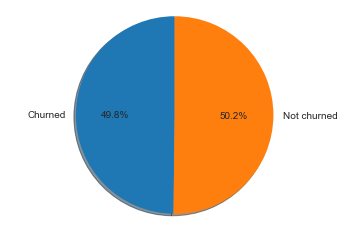

In [36]:
labels = ['Churned', 'Not churned']
fig, ax = plt.subplots()
x = customer_dates[customer_dates['Churn'] == 1]['Churn'].count()
y = customer_dates[customer_dates['Churn'] == 0]['Churn'].count()
ax.pie([x, y], labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')

plt.show()

In [37]:
last_order_date

Timestamp('2018-12-09 00:00:00')

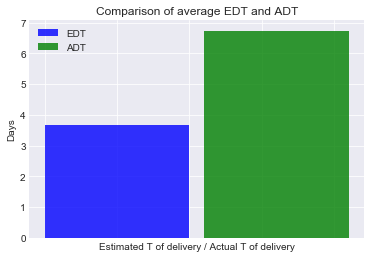

In [38]:
# data to plot
n_groups = 1
mean_edt = customer_dates['EDT'].mean()
mean_adt = customer_dates['ADT'].mean()

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, mean_edt, 0.1,
                 alpha=opacity,
                 color='b',
                 label='EDT')
 
rects2 = plt.bar(index + 0.11, mean_adt, 0.1,
                 alpha=opacity,
                 color='g',
                 label='ADT')
 
plt.xlabel('Estimated T of delivery / Actual T of delivery')
plt.ylabel('Days')
plt.title('Comparison of average EDT and ADT')
plt.tick_params(bottom=False, labelbottom=False)
plt.legend()

plt.show()

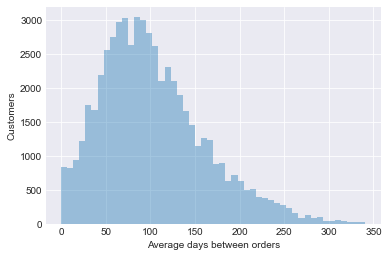

In [39]:
ax = sns.distplot(customer_dates['T_between_orders'], kde=False)
ax.set(xlabel='Average days between orders', ylabel='Customers')
plt.show()

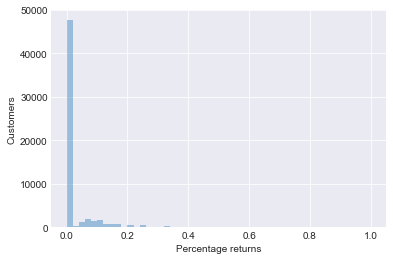

In [40]:
ax = sns.distplot(customer_dates['Percentage returns'], kde=False)
ax.set(ylabel='Customers')
plt.show()

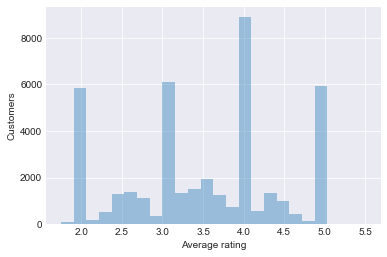

In [41]:
ax = sns.distplot(customer_dates['Average rating'], kde=False, 
                  hist_kws={'range':[1.75,5.5]})
ax.set(ylabel='Customers')
plt.show()

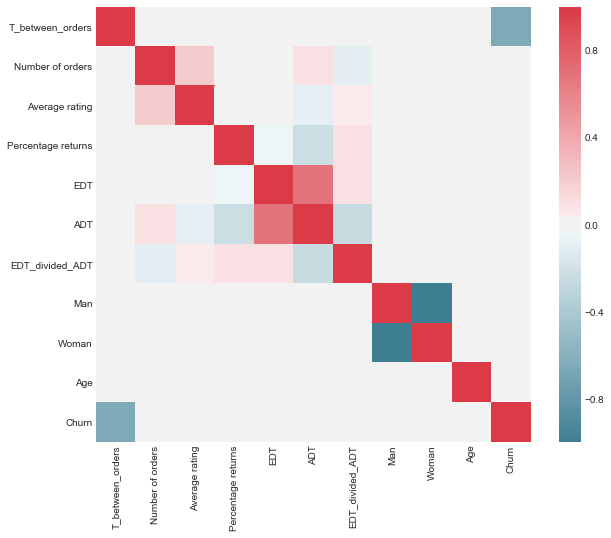

In [42]:
f, ax = plt.subplots(figsize=(10, 8))
corr = customer_dates.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

# Distribution of variables in customer churn

In [44]:
customer_dates.drop('EDT_divided_ADT', inplace = True, axis = 1)
churn     = customer_dates[customer_dates["Churn"] == 1]
not_churn = customer_dates[customer_dates["Churn"] == 0]

targetCol = ["Churn"]
catCols = customer_dates.nunique()[customer_dates.nunique() < 6].keys().tolist()
catCols = [x for x in catCols if x not in targetCol]

numerics = ['float64', 'int64']
numeric_df = customer_dates.select_dtypes(include=numerics)
objects_df = customer_dates.select_dtypes(exclude=numerics)

keyCol = ['Customer number']
numCols = [x for x in customer_dates.columns if x not in catCols + keyCol + targetCol]

In [45]:
from matplotlib.ticker import PercentFormatter

def histChart(column):
    values_churn = churn[column]
    legend = ['Churn', 'Non churn']
    values_nonchurn = not_churn[column]
    plt.hist([values_churn, values_nonchurn], color=['orange', 'blue'], bins=20, rwidth=0.5, density=1)
    #plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.xlabel(column, fontsize=16)
    plt.legend(legend)
    plt.title(column + ' distribution in customer churn', fontsize=16)
    plt.rcParams['figure.figsize'] = (20,7)
    plt.show()

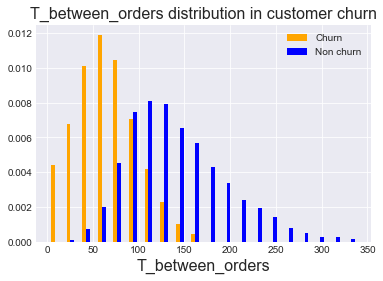

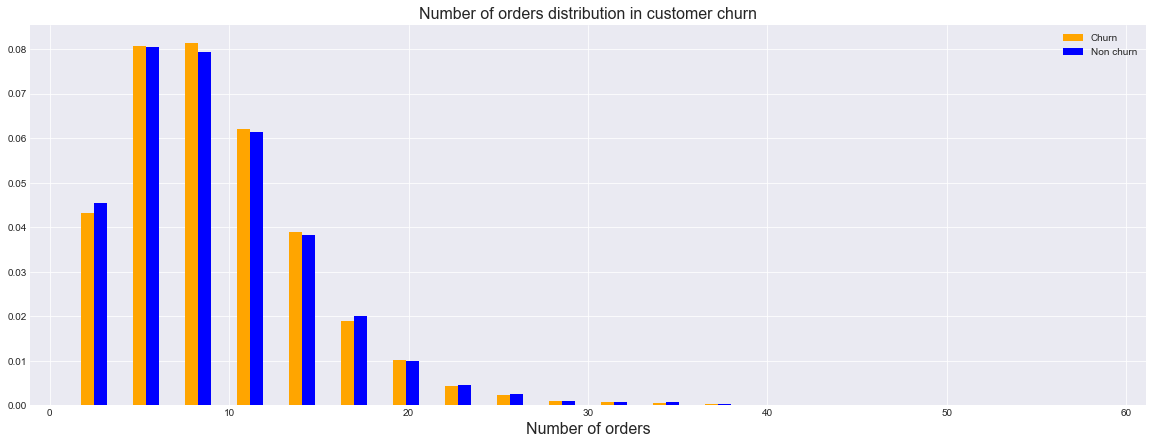

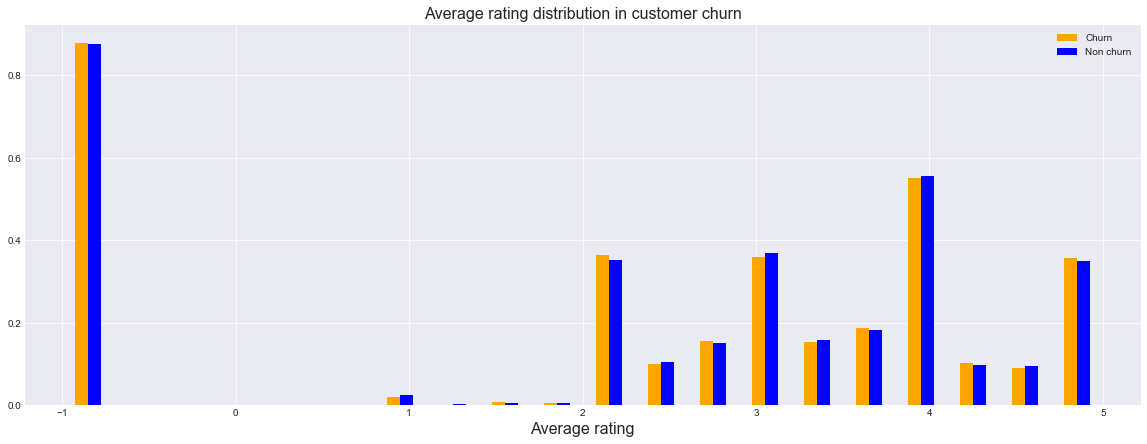

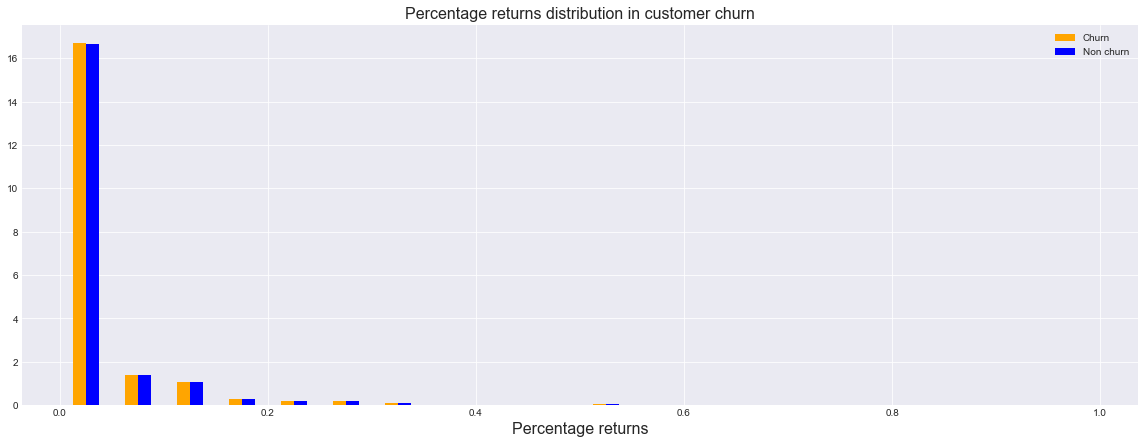

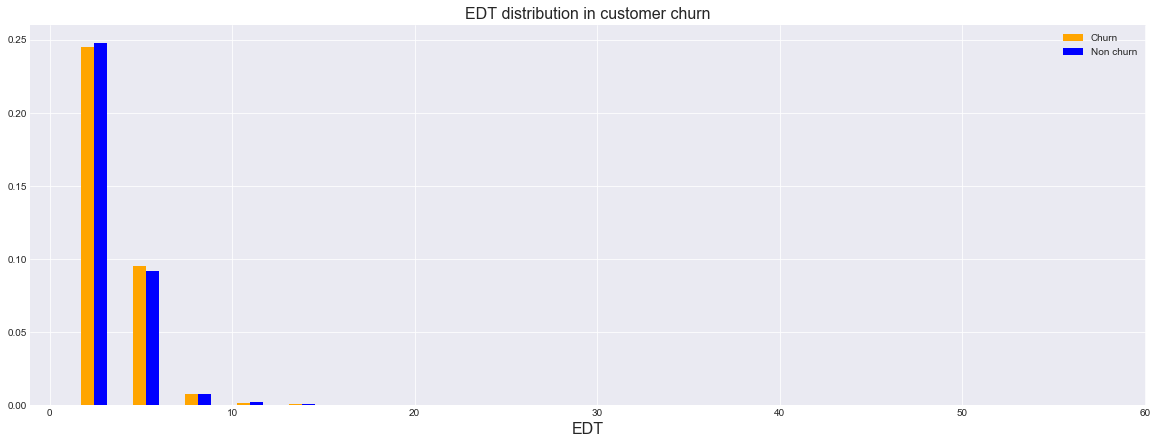

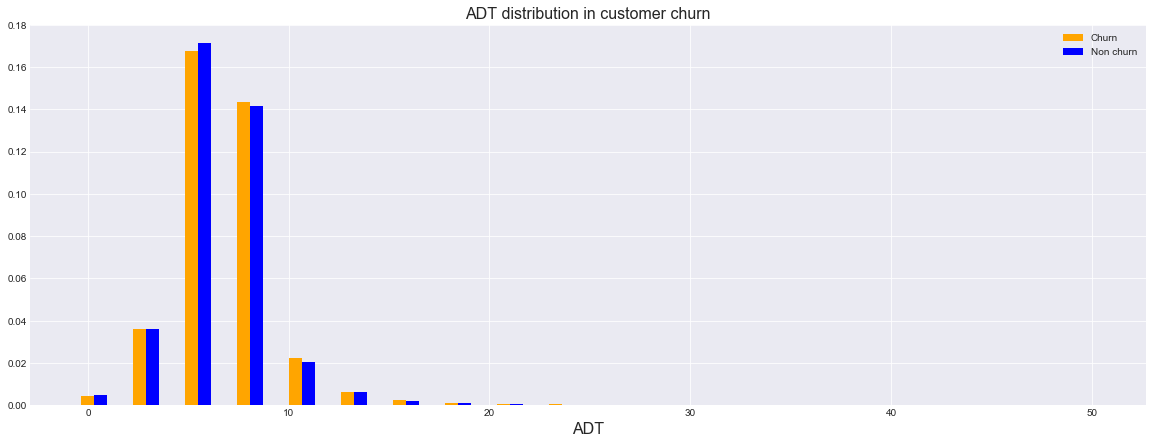

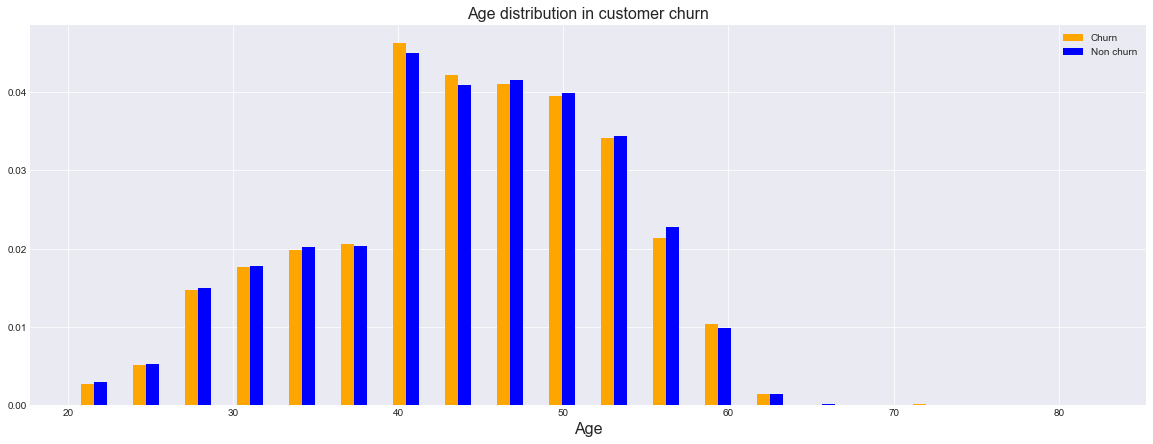

In [46]:
for i in numCols:
    histChart(i)
    print("\n\n")